## 비선형회귀

In [ ]:
# 구글 드라이브에서 파일 가져오기
from google.colab import drive

# Google Drive를 마운트
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/pytorch/non_linear.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 가져온 파일을 판다스로 읽어오기

import pandas as pd
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

# CSV 파일 읽기
df = pd.read_csv(file_path)

# 데이터 확인
df.head()
# df.shape
df.info()

# 데이터 200개 x,y컬럼이 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       200 non-null    float64
 1   y       200 non-null    float64
dtypes: float64(2)
memory usage: 3.2 KB


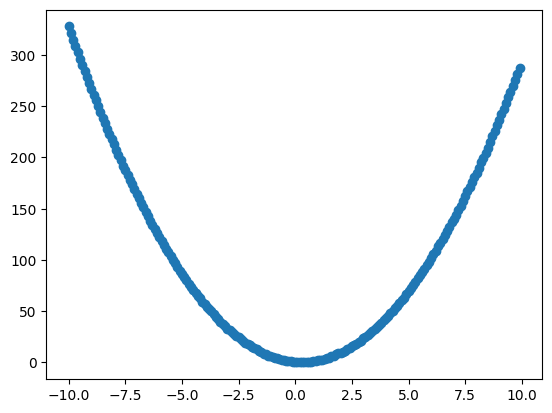

In [ ]:
# EDA

import matplotlib.pyplot as plt

# 2차함수
plt.scatter(df['x'],df['y'])
plt.show()

In [ ]:
class CustomDataset(Dataset):
    def __init__(self,file_path):
        self.data = pd.read_csv(file_path)
        # df['x'] -> 시리즈타입
        self.x = self.data['x'].values
        self.y = self.data['y'].values
        self.length = len(self.data)

    def __getitem__(self,index):
        # custom polynominal_features
        x = torch.FloatTensor([self.x[index]**2, self.x[index]])    #입력이 2개가 됨
        y = torch.FloatTensor([self.y[index]])
        return x,y

    def __len__(self):
        return self.length
        # 여기에서 갯수를 세게 되면 필요할때마다 함수를 호출해서 새롭게 세야하지만
        # init 함수에서 해주면 객체생성될때 한번만 해도 된다.

        # 데이터 갯수가 바뀌거나 자주 늘어나는 경우에는 별도의 함수에서 세어주는것이 나을듯
        # 데이터셋에 따라 다르다!

In [ ]:
train_dataset = CustomDataset(file_path)
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)

In [ ]:
# custom model을 구현

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Linear(2,1)    # x와 x제곱 두개의 컬럼을 입력으로 사용

    def forward(self,x):
        x = self.layer(x)
        return x

In [ ]:
# 처음에는 직접 구현하고 검증되면 클래스로 변환

learning_rate = 0.0001
epochs = 20000
# pytorch에서 사용할 수 있는 장치를 확인하고 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# 모델설정 -> 지금은 cpu
model = CustomModel().to(device)
# 손실함수 설정
criterion = nn.MSELoss().to(device)
# 최적화함수 설정
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
torch.manual_seed(1)
print(torch.manual_seed(1))
torch.cuda.manual_seed(1)

for epoch in range(epochs):
    cost = 0.0
    for x,y in train_dataloader:
        # print(x[:5])
        # print(y[:5])
        # device가 cuda가 되면 cpu -> gpu로 이동
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)
        loss = criterion(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        cost += loss.item()

    cost = cost / len(train_dataloader)

    if epoch % 1000 == 0:
        print(f"epoch : {epoch : 4d}, model : {list(model.parameters())}, cost : {cost:.5f}")



cuda
epoch :    0, model : [Parameter containing:
tensor([[ 2.0543, -0.5763]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.2464], device='cuda:0', requires_grad=True)], cost : 12776.17188
epoch :  1000, model : [Parameter containing:
tensor([[ 3.1032, -1.7031]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.3005], device='cuda:0', requires_grad=True)], cost : 0.09212
epoch :  2000, model : [Parameter containing:
tensor([[ 3.1025, -1.7031]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.3320], device='cuda:0', requires_grad=True)], cost : 0.08722
epoch :  3000, model : [Parameter containing:
tensor([[ 3.1022, -1.7031]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.3584], device='cuda:0', requires_grad=True)], cost : 0.08366
epoch :  4000, model : [Parameter containing:
tensor([[ 3.1018, -1.7031]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([0.3806], device='cuda:0',

In [ ]:
y_pred[:5], y[:5]

(tensor([[ 3.5130],
         [29.5635],
         [25.8745],
         [ 0.9523],
         [86.5130]], device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[ 3.3000],
         [29.2000],
         [26.2000],
         [ 1.0400],
         [86.2900]], device='cuda:0'))

In [ ]:
# 모델 평가하기


# 평가시에는 w와 b값을 업데이트하지 않아야 한다.
with torch.no_grad():
    model.eval()
    inputs = torch.FloatTensor([
        [1 ** 2, 1],
        [5 ** 2, 5],
        [11 ** 2, 11]
    ]).to(device)

    outputs = model(inputs)
    print(outputs)

tensor([[  1.8842],
        [ 69.4674],
        [356.8328]], device='cuda:0')


In [ ]:
# 모델 저장하기

torch.save(model, 'model.pt')

torch.save(model.state_dict(), 'model.state_dict.pt')

In [ ]:
# learning_rate, epoch, batchsize 조절해서 가장 로스값이 적은 파라미터 찾기

# 1. learning_rate : 0.0001 / epoch : 20000 / batchsize = 100
# epoch :  19500, model : [Parameter containing:
# tensor([[ 3.1004, -1.7032]], requires_grad=True), Parameter containing:
# tensor([0.4669], requires_grad=True)], cost : 0.076


# 2. learning_rate : 0.0001  / epoch : 20000 / batchsize = 128(drop_last = True)
# 위 배치사이즈보다 로스값이 작아지는 경우도 많은데 오르락 내리락 한다.
# drop_last = False로 해도 마찬가지


# 3. leraning_rate : 0.001 학습 안됨
# 4. learning_rate : 0.0005 학습은 되는데 값이 오락가락함....

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Colab에서 출력 지우기와 위젯 사용을 위한 모듈 임포트
from IPython.display import clear_output, display
import ipywidgets as widgets

# 데이터 생성
x_data = np.arange(0, 31, 1, dtype=np.float32)
y_data = 2 * x_data + 1

torch.manual_seed(99)

# Tensor로 변환
x_tensor = torch.from_numpy(x_data).unsqueeze(1)  # shape: (31, 1)
y_tensor = torch.from_numpy(y_data).unsqueeze(1)  # shape: (31, 1)

# Dataset과 DataLoader 생성
from torch.utils.data import TensorDataset, DataLoader
batch_size = 5  # batch_size 설정
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 모델 정의
model = nn.Linear(1, 1)

# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

num_epochs = 2000  # epoch 수 설정

# 손실 값을 저장할 리스트 생성
loss_list = [None for i in range(num_epochs)]
epoch_list = [0 for i in range(num_epochs)]

# 버튼과 출력 영역 생성
button = widgets.Button(description="다음 에포크로 진행")
output = widgets.Output()

# 버튼과 출력 영역을 화면에 표시
display(button, output)

# 에포크 초기값 설정
epoch = 0

# 버튼 클릭 시 실행되는 함수 정의
def on_button_clicked(b):
    global epoch  # 전역 변수 epoch 사용
    with output:
        if epoch >= num_epochs:
            print("학습이 완료되었습니다.")
            button.disabled = True  # 버튼 비활성화
            return

        epoch_loss = 0  # 에포크별 손실 누적 변수

        # 한 에포크 동안 학습
        for batch_x, batch_y in dataloader:
            # Forward 연산
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # Backward 연산 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 배치 손실 누적
            epoch_loss += loss.item() * batch_x.size(0)

        # 평균 손실 계산
        avg_loss = epoch_loss / len(dataset)
        loss_list[epoch]=avg_loss
        epoch_list[epoch]=epoch+1

        # 출력 지우기
        clear_output(wait=True)

        # 그래프 그리기
        plt.figure()

        if epoch >= 5:
            print(loss_list[epoch-2:epoch+2])
        else:
            print(loss_list[0:5])
        w, b = list(model.parameters())
        w = w.item()
        b = b.item()
        print(w,b)

        if epoch>0:
            plt.plot(epoch_list[1:], loss_list[1:], 'b-o')

            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title(f'Epoch {epoch+1}/{num_epochs}')
            plt.show()

        epoch += 1

# 버튼 클릭 이벤트에 함수 연결
button.on_click(on_button_clicked)

Button(description='다음 에포크로 진행', style=ButtonStyle())

Output()

<Figure size 640x480 with 0 Axes>